In [1]:
%%time
#sklearn
from sklearn.model_selection import train_test_split,RandomizedSearchCV
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error,explained_variance_score
from sklearn.metrics import mean_squared_error,confusion_matrix, precision_score, recall_score, auc,roc_curve,f1_score
from sklearn import ensemble, linear_model, neighbors, svm, tree, neural_network
import xgboost as xgb

from sklearn.linear_model import Ridge
from sklearn.preprocessing import MinMaxScaler, minmax_scale, KBinsDiscretizer
from sklearn import svm,model_selection, tree, linear_model, neighbors, ensemble, gaussian_process
# from sklearn_extensions.extreme_learning_machines.elm import ELMClassifier,GenELMClassifier
# from sklearn_extensions.extreme_learning_machines.random_layer import  RBFRandomLayer, MLPRandomLayer
from scipy import stats
import tsfel
import optuna as op
from statsmodels.tsa.stattools import acf, pacf


import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import datetime as dt
from math import sqrt
from pandas.plotting import autocorrelation_plot
from utils import series_to_supervised, decompose_time_to_features
from sklearn.metrics import mean_absolute_error
from lightgbm import LGBMRegressor

from datetime import datetime
from pandas.plotting import autocorrelation_plot
from matplotlib import pyplot

# Make numpy values easier to read.
np.set_printoptions(precision=4, suppress=True)

# global variables
seed = 2122022
n_job = 4
n_trial = 100
random_iterations = 100
score = 'neg_mean_squared_error'
cv = 5
lags = 5

import warnings
warnings.filterwarnings('ignore')

Wall time: 5.82 s


In [2]:
def parser(s):
    return datetime.strptime(s,'%m/%d/%Y')

series = pd.read_csv("dataset/uk_wg_p_kg_se.csv")#, 
#                                   parse_dates=[0], index_col=0, squeeze=True, date_parser=parser)
series.head(5)

,year,waste
0,2010-11,325.3
1,2010-11,345.4
2,2010-11,360.0
3,2010-11,318.7
4,2010-11,373.7


In [3]:
series = series.drop(["year"], axis=1)
series.head()

,waste
0,325.3
1,345.4
2,360.0
3,318.7
4,373.7


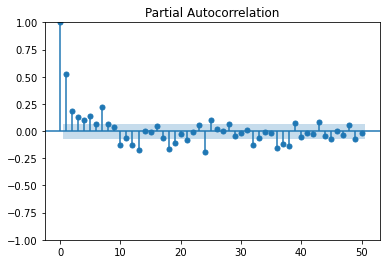

In [4]:
# https://machinelearningmastery.com/gentle-introduction-autocorrelation-partial-autocorrelation/
from statsmodels.tsa.stattools import acf, pacf
from matplotlib import pyplot
from statsmodels.graphics.tsaplots import plot_pacf
plot_pacf(series, lags=50)
pyplot.show()

In [5]:
data = series_to_supervised(series,lags)
# data_date = decompose_time_to_features(series)
data.head(5)

,var1(t-5),var1(t-4),var1(t-3),var1(t-2),var1(t-1),var1(t)
5,325.3,345.4,360.0,318.7,373.7,370.7
6,345.4,360.0,318.7,373.7,370.7,414.7
7,360.0,318.7,373.7,370.7,414.7,384.8
8,318.7,373.7,370.7,414.7,384.8,363.5
9,373.7,370.7,414.7,384.8,363.5,310.8


In [6]:
data.describe()

,var1(t-5),var1(t-4),var1(t-3),var1(t-2),var1(t-1),var1(t)
count,800.000000,800.000000,800.000000,800.000000,800.000000,800.000000
mean,367.601875,367.650500,367.656000,367.796000,367.942500,367.989250
std,51.633138,51.611564,51.609424,51.740374,51.767103,51.789192
min,276.900000,276.900000,276.900000,276.900000,276.900000,276.900000
25%,330.375000,330.550000,330.550000,330.550000,330.675000,330.675000
50%,356.400000,357.000000,357.000000,357.000000,357.500000,357.500000
75%,398.650000,398.650000,398.650000,398.850000,399.225000,399.975000
max,526.400000,526.400000,526.400000,526.400000,526.400000,526.400000


<AxesSubplot:>

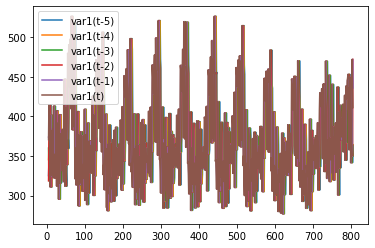

In [7]:
data.plot()

In [8]:
%%time

data_new = data.values
X, y = data_new[:, :-1], data_new[:, -1]

trainX, testX, trainy, testy = train_test_split(X, y, test_size=0.2, random_state=seed)

# from scipy import signal
# sos=signal.butter(4, .8,'low',output='sos') #Wn= cutoff frequency between 0 and 1

# trainX=signal.sosfilt(sos, trainX)
# testX=signal.sosfilt(sos, testX)

# trainX = np.log(trainX)
# testX = np.log(testX)


# X_train, X_test, y_train, y_test
print("shape of our training set",trainX.shape)
print("shape of our testing set",testX.shape)

# check if the slicing is correct
print("shape of our training label",trainy.shape)
print("shape of our testing label",testy.shape)

shape of our training set (640, 5)
shape of our testing set (160, 5)
shape of our training label (640,)
shape of our testing label (160,)
Wall time: 0 ns


In [9]:
scalerX = MinMaxScaler(feature_range=(0, 1))
trainX = scalerX.fit_transform(trainX)
testX = scalerX.transform(testX)

scalery = MinMaxScaler(feature_range=(0, 1))
trainy = scalery.fit_transform(np.reshape(trainy,(trainy.size,1))) 
testy = scalery.transform(np.reshape(testy,(testy.size,1))) 


# check if the slicing is correct
print("shape of our training set",trainX.shape)
print("shape of our testing set",testX.shape)

# check if the slicing is correct
print("shape of our training label",trainy.shape)
print("shape of our testing label",testy.shape)

shape of our training set (640, 5)
shape of our testing set (160, 5)
shape of our training label (640, 1)
shape of our testing label (160, 1)


In [10]:
def multiple_metric_reg(testyy,predictedyy):
    EVS = explained_variance_score(testyy,predictedyy) # best score 1
    R2= r2_score(testyy,predictedyy) # best score 1
    MAE = mean_absolute_error(testyy,predictedyy)
    MAPE = mean_absolute_percentage_error(testyy,predictedyy)
    MSE = mean_squared_error(testyy,predictedyy)
    RMSE = sqrt(mean_squared_error(testyy,predictedyy))
    return EVS, R2, MAE, MAPE, MSE, RMSE

## SVM

In [11]:
# http://education.abcom.com/hyper-parameter-tuning-using-optuna/
# https://stackoverflow.com/questions/69071684/how-to-optimize-for-multiple-metrics-in-optuna
# https://stackoverflow.com/questions/62144904/python-how-to-retrive-the-best-model-from-optuna-lightgbm-study

trainXX, valX, trainyy, valy = train_test_split(trainX, trainy, test_size=0.2, random_state=seed)

def callback(study, trial):
    if study.best_trial.number == trial.number:
        study.set_user_attr(key="best_booster", value=trial.user_attrs["best_booster"])
        
def objective(trial):
    kernel=trial.suggest_categorical('kernel',['rbf','poly','linear','sigmoid'])
    c=trial.suggest_float("C",0.1,3.0,log=True)
    gamma=trial.suggest_categorical('gamma',['auto','scale'])
    degree=trial.suggest_int("degree",1,3,log=True)
    model =svm.SVR(kernel=kernel,degree=degree,gamma=gamma,C=c)
    model.fit(trainXX,trainyy)
    pred = model.predict(valX)
    trial.set_user_attr(key="best_booster", value=model)
    _,_,_,_,mse,_ = multiple_metric_reg(valy, pred)
    return mse

study = op.create_study(direction='minimize')
study.optimize(objective, n_trials=n_trial,n_jobs=-1, callbacks=[callback])

[I 2022-02-26 17:10:23,904] A new study created in memory with name: no-name-3b0e5537-abbc-45e7-8a76-0b5f1102f8a1
[I 2022-02-26 17:10:23,928] Trial 1 finished with value: 0.031396825727948455 and parameters: {'kernel': 'poly', 'C': 0.3778471734711417, 'gamma': 'auto', 'degree': 1}. Best is trial 1 with value: 0.031396825727948455.
[I 2022-02-26 17:10:23,944] Trial 2 finished with value: 0.03264005154462802 and parameters: {'kernel': 'sigmoid', 'C': 0.7721335557582633, 'gamma': 'auto', 'degree': 2}. Best is trial 0 with value: 0.030720703624214155.
[I 2022-02-26 17:10:23,944] Trial 0 finished with value: 0.030720703624214155 and parameters: {'kernel': 'rbf', 'C': 0.6179517552510881, 'gamma': 'auto', 'degree': 2}. Best is trial 0 with value: 0.030720703624214155.
[I 2022-02-26 17:10:23,960] Trial 4 finished with value: 0.030428613875942298 and parameters: {'kernel': 'rbf', 'C': 0.7856902293076127, 'gamma': 'auto', 'degree': 1}. Best is trial 4 with value: 0.030428613875942298.
[I 2022-02

Best Tuning Parameters : {'kernel': 'rbf', 'C': 2.9815728809330873, 'gamma': 'scale', 'degree': 1} 
 with accuracy of : 0.013 %


<AxesSubplot:title={'center':'Parallel Coordinate Plot'}>

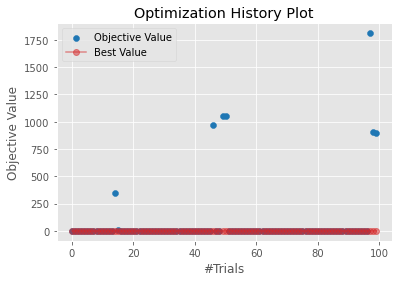

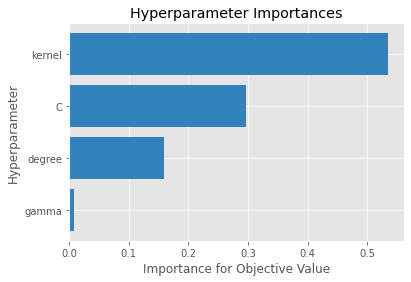

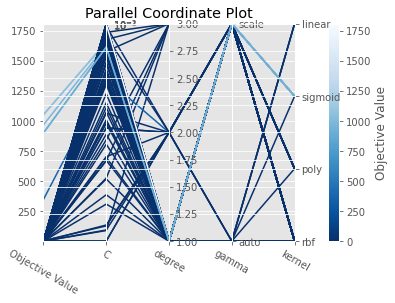

In [12]:
best_svm_model=study.user_attrs["best_booster"]
trial=study.best_trial
print("Best Tuning Parameters : {} \n with accuracy of : {:.3f} %".format(trial.params,trial.value))
op.visualization.matplotlib.plot_optimization_history(study)
op.visualization.matplotlib.plot_param_importances(study)
op.visualization.matplotlib.plot_parallel_coordinate(study)

## XGBOOST

In [13]:
# https://www.analyticsvidhya.com/blog/2021/11/tune-ml-models-in-no-time-with-optuna/

def callback(study, trial):
    if study.best_trial.number == trial.number:
        study.set_user_attr(key="best_booster", value=trial.user_attrs["best_booster"])
        
def objective(trial):

    # XGBoost parameters
    params = {
        "verbosity": 0,  # 0 (silent) - 3 (debug)
        "objective": "reg:squarederror",
        "n_estimators": 10000,
        "max_depth": trial.suggest_int("max_depth", 4, 12),
        "learning_rate": trial.suggest_loguniform("learning_rate", 0.005, 0.05),
        "colsample_bytree": trial.suggest_loguniform("colsample_bytree", 0.2, 0.6),
        "subsample": trial.suggest_loguniform("subsample", 0.4, 0.8),
        "alpha": trial.suggest_loguniform("alpha", 0.01, 10.0),
        "lambda": trial.suggest_loguniform("lambda", 1e-8, 10.0),
        "gamma": trial.suggest_loguniform("lambda", 1e-8, 10.0),
        "min_child_weight": trial.suggest_loguniform("min_child_weight", 10, 1000),
        "seed": seed,
        "n_jobs": -1,
    }
    
    model = xgb.XGBRegressor(random_state=seed, **params)
    model.fit(trainXX,trainyy)
    pred = model.predict(valX)
    trial.set_user_attr(key="best_booster", value=model)
    _,_,_,_,mse,_ = multiple_metric_reg(valy, pred)
    return mse

study1 = op.create_study(direction='minimize')
study1.optimize(objective, n_trials=n_trial,n_jobs=-1, callbacks=[callback])

[I 2022-02-26 17:10:29,946] A new study created in memory with name: no-name-db684f89-169d-40f7-a8bc-f69773a41bb2
[I 2022-02-26 17:10:44,452] Trial 6 finished with value: 0.062930209115626 and parameters: {'max_depth': 5, 'learning_rate': 0.010593408126083531, 'colsample_bytree': 0.48998713096723756, 'subsample': 0.47920728716762, 'alpha': 5.251383094879387, 'lambda': 7.051993028600779e-08, 'min_child_weight': 556.0251335852405}. Best is trial 6 with value: 0.028983594326900154.
[I 2022-02-26 17:10:44,939] Trial 7 finished with value: 0.062930209115626 and parameters: {'max_depth': 7, 'learning_rate': 0.02136027732535372, 'colsample_bytree': 0.3369230000138837, 'subsample': 0.5858239316443657, 'alpha': 0.0601254426697584, 'lambda': 1.0219782356240468e-08, 'min_child_weight': 752.2873601841509}. Best is trial 6 with value: 0.028983594326900154.
[I 2022-02-26 17:10:45,111] Trial 2 finished with value: 0.04438256547768684 and parameters: {'max_depth': 9, 'learning_rate': 0.043697342024827

Best Tuning Parameters : {'max_depth': 10, 'learning_rate': 0.04789154015087699, 'colsample_bytree': 0.478411154614605, 'subsample': 0.734420615838722, 'alpha': 0.20004319392866018, 'lambda': 0.00043978222928178957, 'min_child_weight': 10.288799104822628} 
 with accuracy of : 0.016 %


<AxesSubplot:title={'center':'Hyperparameter Importances'}, xlabel='Importance for Objective Value', ylabel='Hyperparameter'>

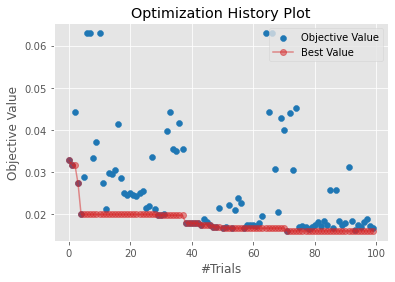

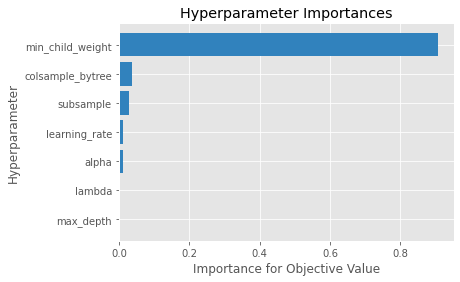

In [14]:
best_xgb_model=study1.user_attrs["best_booster"]
trial=study1.best_trial
print("Best Tuning Parameters : {} \n with accuracy of : {:.3f} %".format(trial.params,trial.value))
op.visualization.matplotlib.plot_optimization_history(study1)
op.visualization.matplotlib.plot_param_importances(study1)
# op.visualization.matplotlib.plot_parallel_coordinate(study1)

## LGBM

In [16]:
# https://www.kaggle.com/luisandresgarcia/optuna?scriptVersionId=83651474
# https://www.kaggle.com/hamzaghanmi/lgbm-hyperparameter-tuning-using-optuna
def callback(study, trial):
    if study.best_trial.number == trial.number:
        study.set_user_attr(key="best_booster", value=trial.user_attrs["best_booster"])

def objective(trial):

    # XGBoost parameters
    params = {
        'metric': 'rmse', 
        'n_estimators': 20000,
        'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-3, 10.0),
        'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-3, 10.0),
        'colsample_bytree': trial.suggest_categorical('colsample_bytree', [0.3,0.4,0.5,0.6,0.7,0.8,0.9, 1.0]),
        'subsample': trial.suggest_categorical('subsample', [0.4,0.5,0.6,0.7,0.8,1.0]),
        'learning_rate': trial.suggest_categorical('learning_rate', [0.006,0.008,0.01,0.014,0.017,0.02]),
        'max_depth': trial.suggest_categorical('max_depth', [10,20,100]),
        'num_leaves' : trial.suggest_int('num_leaves', 1, 1000),
        'min_child_samples': trial.suggest_int('min_child_samples', 1, 300),
        'cat_smooth' : trial.suggest_int('min_data_per_groups', 1, 100)
    }
    
    model = LGBMRegressor(random_state=seed, **params)
    model.fit(trainXX,trainyy)
    pred = model.predict(valX)
    trial.set_user_attr(key="best_booster", value=model)
    _,_,_,_,mse,_ = multiple_metric_reg(valy, pred)
    return mse

study2 = op.create_study(direction='minimize')
study2.optimize(objective, n_trials=n_trial,n_jobs=-1, callbacks=[callback])

[I 2022-02-26 17:27:59,379] A new study created in memory with name: no-name-9b0218b7-027e-45fe-8886-93ad6a467c01
[I 2022-02-26 17:28:00,388] Trial 3 finished with value: 0.04438401969479648 and parameters: {'reg_alpha': 0.009760766420954511, 'reg_lambda': 0.0028953373709576964, 'colsample_bytree': 0.8, 'subsample': 1.0, 'learning_rate': 0.02, 'max_depth': 100, 'num_leaves': 995, 'min_child_samples': 270, 'min_data_per_groups': 31}. Best is trial 3 with value: 0.04438401969479648.
[I 2022-02-26 17:28:01,384] Trial 8 finished with value: 0.04438401969479648 and parameters: {'reg_alpha': 9.000886098349731, 'reg_lambda': 0.016942904814279132, 'colsample_bytree': 1.0, 'subsample': 0.7, 'learning_rate': 0.014, 'max_depth': 100, 'num_leaves': 195, 'min_child_samples': 291, 'min_data_per_groups': 75}. Best is trial 3 with value: 0.04438401969479648.
[I 2022-02-26 17:28:02,872] Trial 4 finished with value: 0.028297770734251403 and parameters: {'reg_alpha': 4.621381728308349, 'reg_lambda': 2.30

Best Tuning Parameters : {'reg_alpha': 0.0013653568594215392, 'reg_lambda': 0.6386761876437862, 'colsample_bytree': 1.0, 'subsample': 0.8, 'learning_rate': 0.014, 'max_depth': 100, 'num_leaves': 878, 'min_child_samples': 14, 'min_data_per_groups': 87} 
 with accuracy of : 0.013 %


<AxesSubplot:title={'center':'Hyperparameter Importances'}, xlabel='Importance for Objective Value', ylabel='Hyperparameter'>

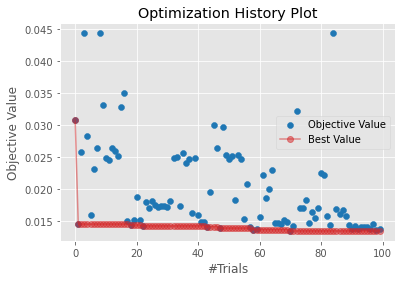

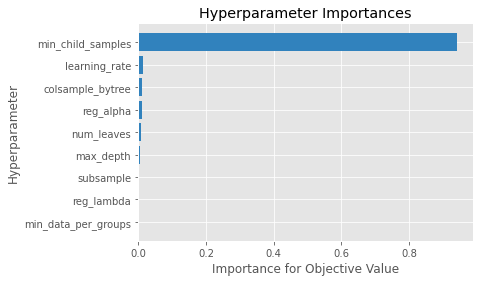

In [17]:
best_lgbm_model=study2.user_attrs["best_booster"]
trial=study2.best_trial
print("Best Tuning Parameters : {} \n with accuracy of : {:.3f} %".format(trial.params,trial.value))
op.visualization.matplotlib.plot_optimization_history(study2)
op.visualization.matplotlib.plot_param_importances(study2)
# op.visualization.matplotlib.plot_parallel_coordinate(study1)

## RANDONM FOREST

In [18]:
import optuna
from optuna import Trial, visualization
from optuna.samplers import TPESampler

def objective(trial):
    
    params = {
        "n_estimators": trial.suggest_int(name="n_estimators", low=100, high=1000),
        "max_depth": trial.suggest_float("max_depth", 4, 50),
        'min_samples_split': trial.suggest_int('min_samples_split', 2.0, 150.0),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 2.0, 60.0),
        "max_features": trial.suggest_categorical(
            "max_features", choices=["auto", "sqrt", "log2"]
        ),
        "n_jobs": -1,
#         "random_state": seed,
    }
    
    clf = ensemble.RandomForestRegressor(random_state=seed, **params)
    clf.fit(trainXX,trainyy)
    pred = clf.predict(valX)
    trial.set_user_attr(key="best_booster", value=clf)
    _,_,_,_,mse,_ = multiple_metric_reg(valy, pred)
    return mse

study3 = op.create_study(direction='minimize')
study3.optimize(objective, n_trials=n_trial,n_jobs=-1, callbacks=[callback])

[I 2022-02-26 17:39:18,943] A new study created in memory with name: no-name-9c5dde84-34a8-4306-94f2-893966e800e8
[I 2022-02-26 17:39:22,749] Trial 4 finished with value: 0.02948132188536695 and parameters: {'n_estimators': 219, 'max_depth': 23.463520251425646, 'min_samples_split': 140, 'min_samples_leaf': 40, 'max_features': 'log2'}. Best is trial 4 with value: 0.02948132188536695.
[I 2022-02-26 17:39:24,480] Trial 1 finished with value: 0.025836708043490593 and parameters: {'n_estimators': 339, 'max_depth': 38.51100317121199, 'min_samples_split': 66, 'min_samples_leaf': 20, 'max_features': 'log2'}. Best is trial 1 with value: 0.025836708043490593.
[I 2022-02-26 17:39:24,902] Trial 3 finished with value: 0.025855068173659373 and parameters: {'n_estimators': 390, 'max_depth': 35.0463651026341, 'min_samples_split': 99, 'min_samples_leaf': 3, 'max_features': 'log2'}. Best is trial 1 with value: 0.025836708043490593.
[I 2022-02-26 17:39:26,474] Trial 5 finished with value: 0.0262007560624

Best Tuning Parameters : {'n_estimators': 211, 'max_depth': 45.615131368232696, 'min_samples_split': 7, 'min_samples_leaf': 2, 'max_features': 'auto'} 
 with accuracy of : 0.014 %


<AxesSubplot:title={'center':'Parallel Coordinate Plot'}>

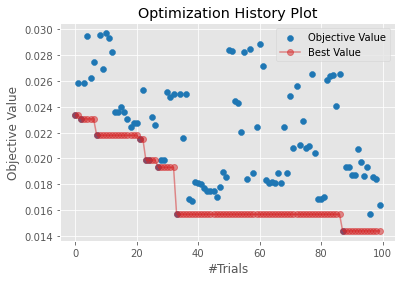

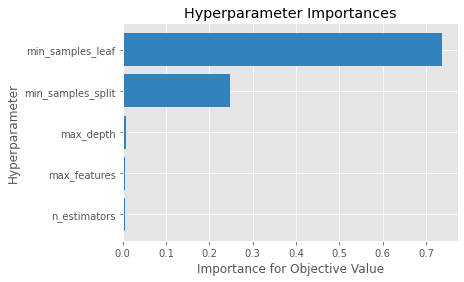

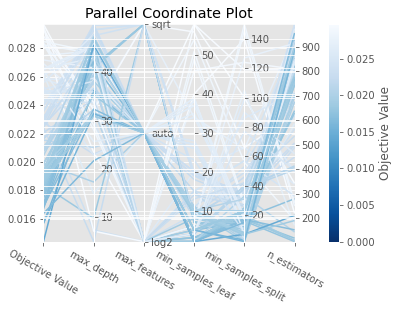

In [19]:
best_rf_model=study3.user_attrs["best_booster"]
trial=study3.best_trial
print("Best Tuning Parameters : {} \n with accuracy of : {:.3f} %".format(trial.params,trial.value))
op.visualization.matplotlib.plot_optimization_history(study3)
op.visualization.matplotlib.plot_param_importances(study3)
op.visualization.matplotlib.plot_parallel_coordinate(study3)

## MultiLayer Perceptron

In [20]:
def objective(trial):

    params = {
        'learning_rate_init': trial.suggest_float('learning_rate_init ', 0.0001, 0.1, step=0.005),
        'first_layer_neurons': trial.suggest_int('first_layer_neurons', 10, 100, step=10),
        'second_layer_neurons': trial.suggest_int('second_layer_neurons', 10, 100, step=10),
        'third_layer_neurons': trial.suggest_int('second_layer_neurons', 10, 100, step=10),
        'activation': trial.suggest_categorical('activation', ['identity', 'tanh', 'relu']),
    }

    model = neural_network.MLPRegressor(
        hidden_layer_sizes=(params['first_layer_neurons'], params['second_layer_neurons'], params['third_layer_neurons']),
        learning_rate_init=params['learning_rate_init'],
        activation=params['activation'],
        random_state=seed,
        max_iter=1000
    )

    model.fit(trainXX,trainyy)
    pred = model.predict(valX)
    trial.set_user_attr(key="best_booster", value=model)
    _,_,_,_,mse,_ = multiple_metric_reg(valy, pred)
    return mse

study4 = op.create_study(direction='minimize')
study4.optimize(objective, n_trials=n_trial,n_jobs=-1, callbacks=[callback])

[I 2022-02-26 17:41:50,105] A new study created in memory with name: no-name-1e96392e-7164-4d1a-8c39-51c768ef433c
[I 2022-02-26 17:42:00,587] Trial 6 finished with value: 0.02994819833866101 and parameters: {'learning_rate_init ': 0.0301, 'first_layer_neurons': 20, 'second_layer_neurons': 70, 'activation': 'identity'}. Best is trial 6 with value: 0.02994819833866101.
[I 2022-02-26 17:42:00,939] Trial 7 finished with value: 0.03077638417293463 and parameters: {'learning_rate_init ': 0.040100000000000004, 'first_layer_neurons': 20, 'second_layer_neurons': 70, 'activation': 'identity'}. Best is trial 6 with value: 0.02994819833866101.
[I 2022-02-26 17:42:01,474] Trial 1 finished with value: 0.027991500222475173 and parameters: {'learning_rate_init ': 0.0051, 'first_layer_neurons': 90, 'second_layer_neurons': 30, 'activation': 'tanh'}. Best is trial 1 with value: 0.027991500222475173.
[I 2022-02-26 17:42:02,861] Trial 3 finished with value: 0.02959908833514476 and parameters: {'learning_ra

Best Tuning Parameters : {'learning_rate_init ': 0.0201, 'first_layer_neurons': 70, 'second_layer_neurons': 10, 'activation': 'relu'} 
 with accuracy of : 0.013 %


<AxesSubplot:title={'center':'Parallel Coordinate Plot'}>

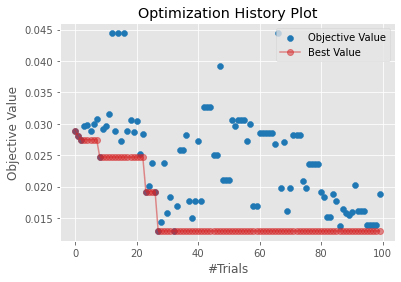

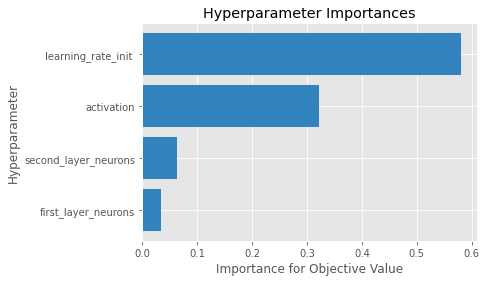

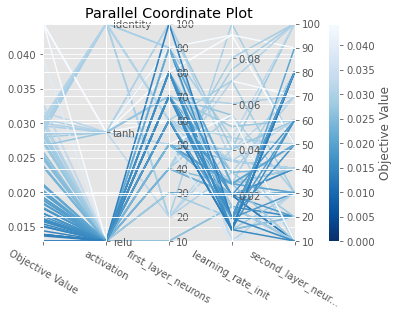

In [21]:
best_mlp_model=study4.user_attrs["best_booster"]
trial=study4.best_trial
print("Best Tuning Parameters : {} \n with accuracy of : {:.3f} %".format(trial.params,trial.value))
op.visualization.matplotlib.plot_optimization_history(study4)
op.visualization.matplotlib.plot_param_importances(study4)
op.visualization.matplotlib.plot_parallel_coordinate(study4)

## KNN

In [22]:
# https://www.kaggle.com/sashatarakanova/knn-with-hyperparameter-tuning-using-optuna
import optuna
from optuna import Trial, visualization
from optuna.samplers import TPESampler

import optuna
from optuna.samplers import TPESampler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
# https://machinelearningmastery.com/hyperparameters-for-classification-machine-learning-algorithms/

def objective(trial):
                
    # -- Tune estimator algorithm
    n_neighbors = trial.suggest_int("n_neighbors", 1, 30)
    weights = trial.suggest_categorical("weights", ['uniform', 'distance'])
    metric = trial.suggest_categorical("metric", ['euclidean', 'manhattan', 'minkowski'])
    knn = neighbors.KNeighborsRegressor(n_neighbors=n_neighbors, weights=weights, metric=metric)
    
    knn.fit(trainXX,trainyy)
    pred = knn.predict(valX)
    trial.set_user_attr(key="best_booster", value=knn)
    _,_,_,_,mse,_ = multiple_metric_reg(valy, pred)
    return mse

study5 = op.create_study(direction='minimize')
study5.optimize(objective, n_trials=n_trial,n_jobs=-1, callbacks=[callback])

[I 2022-02-26 17:45:32,649] A new study created in memory with name: no-name-ac4bc082-53ed-453d-a101-81931f5e8f65
[I 2022-02-26 17:45:32,833] Trial 0 finished with value: 0.018986020873786646 and parameters: {'n_neighbors': 16, 'weights': 'uniform', 'metric': 'manhattan'}. Best is trial 0 with value: 0.018986020873786646.
[I 2022-02-26 17:45:32,855] Trial 3 finished with value: 0.02123052083726571 and parameters: {'n_neighbors': 25, 'weights': 'uniform', 'metric': 'manhattan'}. Best is trial 1 with value: 0.015657278635905058.
[I 2022-02-26 17:45:32,864] Trial 5 finished with value: 0.013156339721332793 and parameters: {'n_neighbors': 11, 'weights': 'distance', 'metric': 'manhattan'}. Best is trial 5 with value: 0.013156339721332793.
[I 2022-02-26 17:45:32,866] Trial 1 finished with value: 0.015657278635905058 and parameters: {'n_neighbors': 26, 'weights': 'distance', 'metric': 'minkowski'}. Best is trial 1 with value: 0.013156339721332793.
[I 2022-02-26 17:45:32,869] Trial 4 finished 

Best Tuning Parameters : {'n_neighbors': 1, 'weights': 'distance', 'metric': 'euclidean'} 
 with accuracy of : 0.007 %


<AxesSubplot:title={'center':'Parallel Coordinate Plot'}>

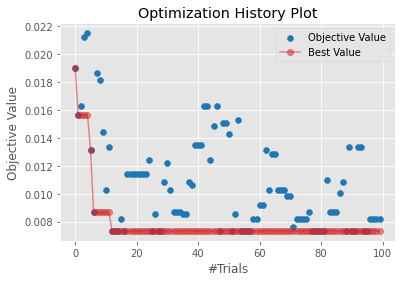

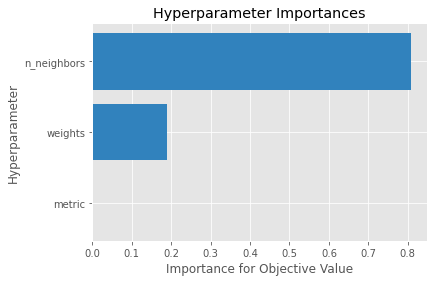

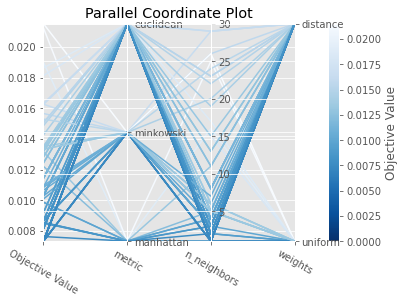

In [23]:
best_knn_model=study5.user_attrs["best_booster"]
trial=study5.best_trial
print("Best Tuning Parameters : {} \n with accuracy of : {:.3f} %".format(trial.params,trial.value))
op.visualization.matplotlib.plot_optimization_history(study5)
op.visualization.matplotlib.plot_param_importances(study5)
op.visualization.matplotlib.plot_parallel_coordinate(study5)

## XTREES FOREST

In [24]:
import optuna
from optuna import Trial, visualization
from optuna.samplers import TPESampler

def objective(trial):
    
    params = {
        "n_estimators": trial.suggest_int(name="n_estimators", low=100, high=1000),
        "max_depth": trial.suggest_float("max_depth", 4, 50),
        'min_samples_split': trial.suggest_int('min_samples_split', 2.0, 150.0),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 2.0, 60.0),
        "max_features": trial.suggest_categorical(
            "max_features", choices=["auto", "sqrt", "log2"]
        ),
        "n_jobs": -1,
#         "random_state": seed,
    }
    
    clf = ensemble.ExtraTreesRegressor(random_state=seed, **params)
    clf.fit(trainXX,trainyy)
    pred = clf.predict(valX)
    trial.set_user_attr(key="best_booster", value=clf)
    _,_,_,_,mse,_ = multiple_metric_reg(valy, pred)
    return mse

study6 = op.create_study(direction='minimize')
study6.optimize(objective, n_trials=n_trial,n_jobs=-1, callbacks=[callback])

[I 2022-02-26 17:45:36,988] A new study created in memory with name: no-name-54a1353c-8c71-4f88-88d7-fb4086d1c326
[I 2022-02-26 17:45:40,707] Trial 4 finished with value: 0.03138734726200257 and parameters: {'n_estimators': 263, 'max_depth': 49.94136001511548, 'min_samples_split': 130, 'min_samples_leaf': 15, 'max_features': 'sqrt'}. Best is trial 4 with value: 0.03138734726200257.
[I 2022-02-26 17:45:40,760] Trial 1 finished with value: 0.03585124460061177 and parameters: {'n_estimators': 304, 'max_depth': 29.819214213222043, 'min_samples_split': 21, 'min_samples_leaf': 60, 'max_features': 'sqrt'}. Best is trial 1 with value: 0.03138734726200257.
[I 2022-02-26 17:45:41,292] Trial 2 finished with value: 0.03112063528941754 and parameters: {'n_estimators': 352, 'max_depth': 11.230066507409063, 'min_samples_split': 59, 'min_samples_leaf': 24, 'max_features': 'log2'}. Best is trial 2 with value: 0.03112063528941754.
[I 2022-02-26 17:45:45,017] Trial 7 finished with value: 0.03298252905945

Best Tuning Parameters : {'n_estimators': 977, 'max_depth': 37.89431526163344, 'min_samples_split': 6, 'min_samples_leaf': 2, 'max_features': 'auto'} 
 with accuracy of : 0.012 %


<AxesSubplot:title={'center':'Parallel Coordinate Plot'}>

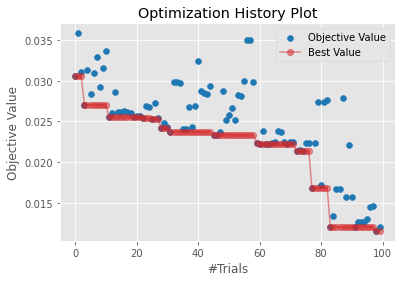

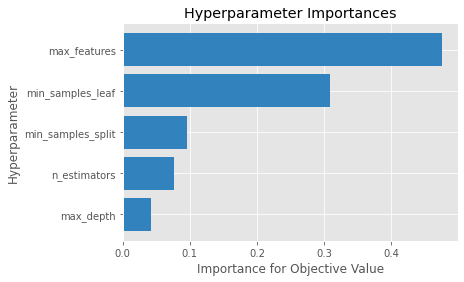

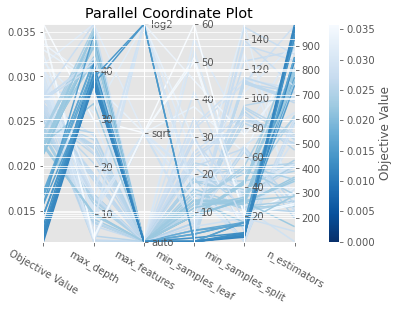

In [25]:
best_ets_model=study6.user_attrs["best_booster"]
trial=study6.best_trial
print("Best Tuning Parameters : {} \n with accuracy of : {:.3f} %".format(trial.params,trial.value))
op.visualization.matplotlib.plot_optimization_history(study6)
op.visualization.matplotlib.plot_param_importances(study6)
op.visualization.matplotlib.plot_parallel_coordinate(study6)

In [26]:
MLA = [best_svm_model,best_rf_model,best_xgb_model, best_lgbm_model, best_mlp_model,best_knn_model, best_ets_model]

In [27]:
# https://machinelearningmastery.com/super-learner-ensemble-in-python/

from math import sqrt
from numpy import hstack
from numpy import vstack
from numpy import asarray
from sklearn.model_selection import KFold
from sklearn.linear_model import LinearRegression


# collect out of fold predictions form k-fold cross validation
def get_out_of_fold_predictions(X, y, models):
	meta_X, meta_y = list(), list()
	# define split of data
	kfold = KFold(n_splits=5, shuffle=True)
	# enumerate splits
	for train_ix, test_ix in kfold.split(X):
		fold_yhats = list()
		# get data
		train_X, test_X = X[train_ix], X[test_ix]
		train_y, test_y = y[train_ix], y[test_ix]
		meta_y.extend(test_y)
		# fit and make predictions with each sub-model
		for model in models:
# 			model.fit(train_X, train_y)
			yhat = model.predict(test_X)
			# store columns
			fold_yhats.append(yhat.reshape(len(yhat),1))
		# store fold yhats as columns
		meta_X.append(hstack(fold_yhats))
	return vstack(meta_X), asarray(meta_y)

# fit all base models on the training dataset
def fit_base_models(X, y, models):
	for model in models:
		model.fit(X, y)
 
# fit a meta model
def fit_meta_model(X, y):
	model = LinearRegression()
	model.fit(X, y)
	return model

# evaluate a list of models on a dataset
def evaluate_models(X, y, models):
	for model in models:
		yhat = model.predict(X)
		mse = mean_squared_error(y, yhat)
		print('%s: RMSE %.3f' % (model.__class__.__name__, sqrt(mse)))
        
# make predictions with stacked model
def super_learner_predictions(X, models, meta_model):
	meta_X = list()
	for model in models:
		yhat = model.predict(X)
		meta_X.append(yhat.reshape(len(yhat),1))
	meta_X = hstack(meta_X)
	# predict
	return meta_model.predict(meta_X), meta_X


In [28]:
# Stacked Ensemble learning
# get out of fold predictions
meta_X, meta_y = get_out_of_fold_predictions(trainX, trainy, MLA)
print('Meta ', meta_X.shape, meta_y.shape)
# fit base models
# fit_base_models(trainX, trainy, models)
# fit the meta model
meta_model = fit_meta_model(meta_X, meta_y)
# evaluate base models
evaluate_models(testX, testy, MLA)
# evaluate meta model
yhat, meta_mx = super_learner_predictions(testX, MLA, meta_model)
print('Super Learner: RMSE %.3f' % (sqrt(mean_squared_error(testy, yhat))))

Meta  (640, 7) (640, 1)
SVR: RMSE 0.117
RandomForestRegressor: RMSE 0.115
XGBRegressor: RMSE 0.122
LGBMRegressor: RMSE 0.114
MLPRegressor: RMSE 0.122
KNeighborsRegressor: RMSE 0.106
ExtraTreesRegressor: RMSE 0.110
Super Learner: RMSE 0.096


In [29]:
# Results of super learner
EVS = explained_variance_score(testy, yhat) # best score 1
R2= r2_score(testy, yhat) # best score 1
MAE = mean_absolute_error(testy, yhat)
MAPE = mean_absolute_percentage_error(testy, yhat)
MSE = mean_squared_error(testy, yhat)
RMSE = sqrt(mean_squared_error(testy, yhat))
print('Test R2: %.3f' % R2)
print('Test MAE: %.3f' % MAE)
print('Test MAPE: %.3f' % MAPE)
print('Test MSE: %.3f' % MSE)
print('Test RMSE: %.3f' % RMSE)
print('Test Explained_Variance_Score: %.3f' % EVS)

Test R2: 0.796
Test MAE: 0.059
Test MAPE: 0.263
Test MSE: 0.009
Test RMSE: 0.096
Test Explained_Variance_Score: 0.796


In [30]:
# Voting ensemble
syhat = np.sum( np.asarray(meta_mx), axis = 1)/meta_mx.shape[1]
EVS = explained_variance_score(testy, syhat) # best score 1
R2= r2_score(testy, syhat) # best score 1
MAE = mean_absolute_error(testy, syhat)
MAPE = mean_absolute_percentage_error(testy, syhat)
MSE = mean_squared_error(testy, syhat)
RMSE = sqrt(mean_squared_error(testy, syhat))
print('Test R2: %.3f' % R2)
print('Test MAE: %.3f' % MAE)
print('Test MAPE: %.3f' % MAPE)
print('Test MSE: %.3f' % MSE)
print('Test RMSE: %.3f' % RMSE)
print('Test Explained_Variance_Score: %.3f' % EVS)

Test R2: 0.782
Test MAE: 0.074
Test MAPE: 0.333
Test MSE: 0.010
Test RMSE: 0.099
Test Explained_Variance_Score: 0.783


In [31]:
%%time
MLA_columns = []
MLA_compare = pd.DataFrame(columns = MLA_columns)

row_index = 0
for alg in MLA:
    predictedy = alg.predict(testX)
    testyy,predictedyy = scalery.inverse_transform(testy),scalery.inverse_transform(np.reshape(predictedy,(predictedy.size,1)))
    
    MLA_name = alg.__class__.__name__
    MLA_compare.loc[row_index,'MLA Name'] = MLA_name
    MLA_compare.loc[row_index,'Parameters'] = str(alg)
    
    EVS = explained_variance_score(testyy,predictedyy) # best score 1
    R2= r2_score(testyy,predictedyy) # best score 1
    MAE = mean_absolute_error(testyy,predictedyy)
    MAPE = mean_absolute_percentage_error(testyy,predictedyy)
    MSE = mean_squared_error(testyy,predictedyy)
    RMSE = sqrt(mean_squared_error(testyy,predictedyy))
    
    MLA_compare.loc[row_index, 'R2 score'] = round(R2, 4)
    MLA_compare.loc[row_index, 'MAE'] = round(MAE, 4)
    MLA_compare.loc[row_index, 'MAPE'] = round(MAPE, 4)
    MLA_compare.loc[row_index, 'MSE'] = round(MSE, 4)    
    MLA_compare.loc[row_index, 'RMSE'] = round(RMSE, 4)
    MLA_compare.loc[row_index, 'EVS'] = round(EVS, 4)
    
    YEVS = explained_variance_score(testy,predictedy) # best score 1
    YR2= r2_score(testy,predictedy) # best score 1
    YMAE = mean_absolute_error(testy,predictedy)
    YMAPE = mean_absolute_percentage_error(testy,predictedy)
    YMSE = mean_squared_error(testy,predictedy)
    YRMSE = sqrt(mean_squared_error(testy,predictedy))
    
    MLA_compare.loc[row_index, 'YR2 score'] = round(YR2, 4)
    MLA_compare.loc[row_index, 'YMAE'] = round(YMAE, 4)
    MLA_compare.loc[row_index, 'YMAPE'] = round(YMAPE, 4)
    MLA_compare.loc[row_index, 'YMSE'] = round(YMSE, 4)
    MLA_compare.loc[row_index, 'YRMSE'] = round(YRMSE, 4)
    MLA_compare.loc[row_index, 'YEVS'] = round(YEVS, 4)
    
    
    row_index+=1
    
MLA_compare.sort_values(by = ['YR2 score'], ascending = False, inplace = True)    
MLA_compare

Wall time: 531 ms


,MLA Name,Parameters,R2 score,MAE,MAPE,MSE,RMSE,EVS,YR2 score,YMAE,YMAPE,YMSE,YRMSE,YEVS
5,KNeighborsRegressor,"KNeighborsRegressor(metric='euclidean', n_neig...",0.7489,16.2738,0.0437,699.4536,26.4472,0.7493,0.7489,0.0652,0.2816,0.0112,0.1060,0.7493
6,ExtraTreesRegressor,ExtraTreesRegressor(max_depth=37.8943152616334...,0.7281,20.8030,0.0561,757.5808,27.5242,0.7281,0.7281,0.0834,0.3618,0.0122,0.1103,0.7281
3,LGBMRegressor,"LGBMRegressor(cat_smooth=87, learning_rate=0.0...",0.7109,20.4425,0.0548,805.3911,28.3794,0.7109,0.7109,0.0819,0.3444,0.0129,0.1137,0.7109
1,RandomForestRegressor,RandomForestRegressor(max_depth=45.61513136823...,0.7035,21.8383,0.0592,825.9021,28.7385,0.7038,0.7035,0.0875,0.3885,0.0133,0.1152,0.7038
0,SVR,"SVR(C=2.9815728809330873, degree=1)",0.6916,23.1245,0.0620,859.1524,29.3113,0.6969,0.6916,0.0927,0.4013,0.0138,0.1175,0.6969
2,XGBRegressor,"XGBRegressor(alpha=0.20004319392866018, base_s...",0.6670,22.7261,0.0619,927.7730,30.4594,0.6670,0.6670,0.0911,0.4121,0.0149,0.1221,0.6670
4,MLPRegressor,"MLPRegressor(hidden_layer_sizes=(70, 10, 10), ...",0.6658,23.3281,0.0616,931.1392,30.5146,0.6871,0.6658,0.0935,0.3902,0.0150,0.1223,0.6871
